
# Getting Started: Wang (2006) Cross‑Wind Integrated Footprint
This notebook shows how to use the `wang_footprint.py` module from the **fluxfootprints** library to compute the Wang et al. (2006) cross‑wind‑integrated footprint, and (optionally) reconstruct a 2‑D footprint by assuming a Gaussian lateral spread.

**What you'll do**
1. Import the Wang (2006) functions from your local `src` checkout.
2. Compute the 1‑D cross‑wind integrated footprint \(f_y(x)\).
3. (Optional) Reconstruct a 2‑D footprint \(f(x, y)\) and visualize it.
4. Extract practical distances (e.g., x for 50%, 80%, 90% cumulative contribution).

> **CBL validity:** The Wang (2006) parameterisation targets convective daytime conditions and requires **negative** Monin‑Obukhov length `L < 0`. Use with caution outside the published range.


In [1]:

# --- Setup & Imports ----------------------------------------------------------
import os, sys, math, numpy as np

# Use your local project layout: notebook in e.g. `notebooks/`, package in `src/`
# The user requested: use sys.path.append("../../src")
sys.path.append("../../src")

# Now import from the package/module
from fluxfootprints.wang_footprint import wang2006_fy, reconstruct_gaussian_2d
print("Imports OK. Using fluxfootprints from:", [p for p in sys.path if p.endswith("/src")])


Imports OK. Using fluxfootprints from: ['../../src']


In [2]:

# --- Quick environment check --------------------------------------------------
import numpy as np, matplotlib
print("NumPy:", np.__version__)
print("Matplotlib:", matplotlib.__version__)

# Optional: show docstring summaries
print("\nwang2006_fy:", wang2006_fy.__doc__.splitlines()[0])
print("reconstruct_gaussian_2d:", reconstruct_gaussian_2d.__doc__.splitlines()[0])


NumPy: 2.2.2
Matplotlib: 3.10.0

wang2006_fy: Cross‑wind integrated footprint ``f_y(x)`` (m⁻¹).
reconstruct_gaussian_2d: Reconstruct a 2‑D footprint ``f(x,y)`` from a 1‑D ``f_y(x)``.



## 1) Provide inputs
You need:
- `zm` — measurement height above ground (m)
- `h` — convective boundary‑layer height (m)
- `L` — Monin‑Obukhov length (**negative** for convective)
- Optional: `U` (mean wind speed, m s⁻¹) and `sigma_v` (lateral velocity std, m s⁻¹) to define the lateral spread for the 2‑D reconstruction.

Below, the cell will try to discover any example CSV/JSON in a nearby `examples/` or `data/` folder.
If none is found, it will fall back to a synthetic convective case that produces a reasonable footprint.


In [3]:

# --- Try to auto‑discover example inputs -------------------------------------
from pathlib import Path
import json, csv

def try_load_examples():
    candidates = [
        Path("../examples"), Path("../../examples"),
        Path("./examples"), Path("../data"), Path("../../data")
    ]
    # Simple heuristics: look for small CSV/JSON that might contain zm,h,L,U,sigma_v
    for base in candidates:
        if not base.exists(): 
            continue
        for ext in ("*.csv", "*.json"):
            for f in base.glob(ext):
                try:
                    if f.suffix.lower() == ".json":
                        with open(f, "r", encoding="utf-8") as fp:
                            data = json.load(fp)
                        keys = {k.lower() for k in data.keys()}
                        if {"zm","h","l"}.issubset(keys):
                            return dict(zm=float(data["zm"]), h=float(data["h"]), L=float(data["l"]),
                                        U=float(data.get("U", 3.5)), sigma_v=float(data.get("sigma_v", 0.6))), f
                    else:  # CSV
                        with open(f, "r", encoding="utf-8") as fp:
                            reader = csv.DictReader(fp)
                            for row in reader:
                                keys = {k.lower() for k in row.keys()}
                                if {"zm","h","l"}.issubset(keys):
                                    return dict(zm=float(row["zm"]), h=float(row["h"]), L=float(row["L"]),
                                                U=float(row.get("U", 3.5)), sigma_v=float(row.get("sigma_v", 0.6))), f
                except Exception:
                    # Not an expected format; keep scanning
                    pass
    return None, None

params, src_file = try_load_examples()

if params is None:
    # Fallback: synthetic daytime convective case
    params = dict(
        zm=3.0,     # m
        h=800.0,    # m
        L=-120.0,   # m  (must be negative for convective)
        U=3.5,      # m/s
        sigma_v=0.6 # m/s
    )
    print("No example file found. Using synthetic parameters:", params)
else:
    print(f"Loaded example parameters from {src_file}: {params}")

zm, h, L, U, sigma_v = params["zm"], params["h"], params["L"], params["U"], params["sigma_v"]
assert L < 0.0, "Wang (2006) requires convective conditions (L < 0)."


No example file found. Using synthetic parameters: {'zm': 3.0, 'h': 800.0, 'L': -120.0, 'U': 3.5, 'sigma_v': 0.6}



## 2) Compute the 1‑D cross‑wind‑integrated footprint \(f_y(x)\)
We'll evaluate \(f_y(x)\) along a stream‑wise distance vector `x` (positive upwind).


In [5]:

import numpy as np

# Stream‑wise grid (m); extend far enough upwind for the tail to decay
x = np.linspace(0.0, 6000.0, 601)  # 10 m spacing
fy = wang2006_fy(x, zm=zm, h=h, L=L)

# Basic checks
dx = x[1] - x[0]
mass = np.trapezoid(fy, x)
print(f"Integral ∫ f_y dx ≈ {mass:.6f} (should be ~1.0)")
print(f"Max f_y at x ≈ {x[np.argmax(fy)]:.1f} m")


Integral ∫ f_y dx ≈ 1.000000 (should be ~1.0)
Max f_y at x ≈ 10.0 m


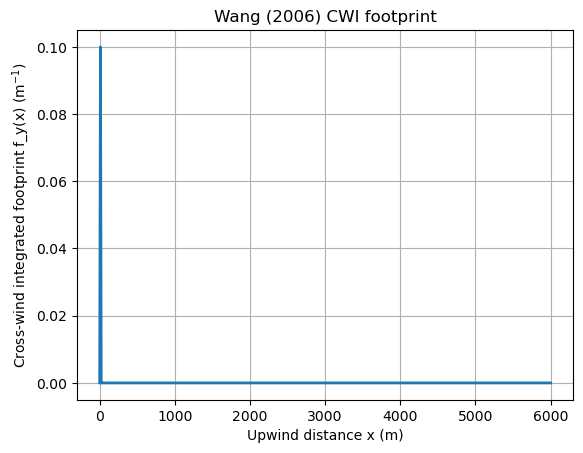

In [6]:

# --- Plot f_y(x) --------------------------------------------------------------
import matplotlib.pyplot as plt

plt.figure()
plt.plot(x, fy, lw=2)
plt.xlabel("Upwind distance x (m)")
plt.ylabel("Cross-wind integrated footprint f_y(x) (m$^{-1}$)")
plt.title("Wang (2006) CWI footprint")
plt.grid(True)
plt.show()



## 3) Practical distances by cumulative contribution
You can extract distances that capture a chosen fraction of the source area (e.g., 50%, 80%, 90%) by integrating \(f_y(x)\).


In [7]:

cum = np.cumsum(fy) * (x[1] - x[0])

def x_at_fraction(frac):
    idx = np.searchsorted(cum, frac)
    return float(x[min(idx, len(x)-1)])

x50, x80, x90 = x_at_fraction(0.50), x_at_fraction(0.80), x_at_fraction(0.90)
print(f"x_50% ≈ {x50:.1f} m,  x_80% ≈ {x80:.1f} m,  x_90% ≈ {x90:.1f} m")


x_50% ≈ 10.0 m,  x_80% ≈ 10.0 m,  x_90% ≈ 10.0 m


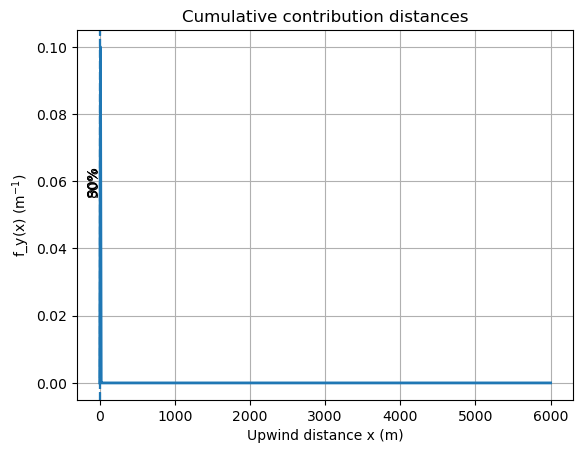

In [8]:

# Re-plot with markers for 50/80/90%
import matplotlib.pyplot as plt

plt.figure()
plt.plot(x, fy, lw=2)
for xv, label in [(x50, "50%"), (x80, "80%"), (x90, "90%")]:
    plt.axvline(x=xv, ls="--")
    plt.text(xv, max(fy)*0.6, label, rotation=90, va="center", ha="right")
plt.xlabel("Upwind distance x (m)")
plt.ylabel("f_y(x) (m$^{-1}$)")
plt.title("Cumulative contribution distances")
plt.grid(True)
plt.show()



## 4) (Optional) Reconstruct a 2‑D footprint \(f(x, y)\)
Use a Gaussian lateral distribution with width \(\sigma_y(x)\). By default,
\(\sigma_y = \alpha x\) with \(\alpha \approx 0.3\). If you have turbulence stats,
you can pass `sigma_v` and `U` to use \(\sigma_y = (\sigma_v/U)\,x\).


In [9]:

# Compute the 2-D reconstruction using turbulence-based sigma_y
X, Y, F = reconstruct_gaussian_2d(x, fy, sigma_v=sigma_v, U=U, ny=241)

# Sanity check: F integrates to ~1 over the domain
dx = x[1] - x[0]
dy = Y[1,0] - Y[0,0]
mass2d = np.sum(F * dx * dy)
print(f"Double integral ∬ F dx dy ≈ {mass2d:.6f}")


Double integral ∬ F dx dy ≈ 1.000000


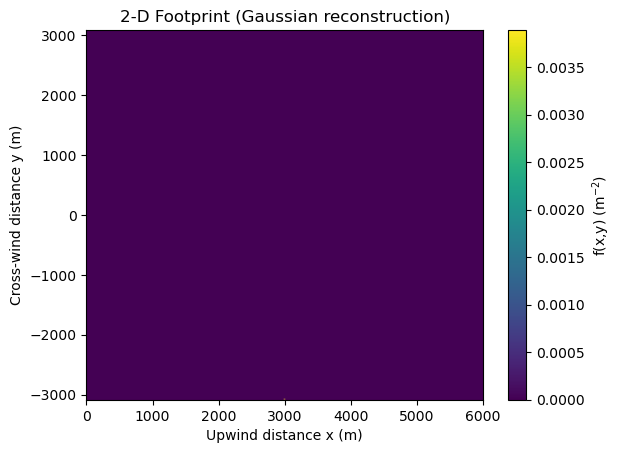

In [10]:

# --- Visualize the 2-D footprint ---------------------------------------------
import matplotlib.pyplot as plt
extent = [x.min(), x.max(), Y.min(), Y.max()]

plt.figure()
plt.imshow(F.T, origin="lower", aspect="auto", extent=extent)
plt.colorbar(label="f(x,y) (m$^{-2}$)")
plt.xlabel("Upwind distance x (m)")
plt.ylabel("Cross-wind distance y (m)")
plt.title("2-D Footprint (Gaussian reconstruction)")
plt.show()



## 5) Save results
These examples show how to export the computed arrays to common formats.


In [11]:

# Save 1-D footprint to CSV
import pandas as pd
one_d = pd.DataFrame({"x_m": x, "f_y_per_m": fy, "cum_frac": np.cumsum(fy)*(x[1]-x[0])})
one_d.to_csv("wang2006_fy_example.csv", index=False)
print("Wrote: wang2006_fy_example.csv")

# Save 2-D footprint as NumPy .npz
np.savez_compressed("wang2006_2d_example.npz", X=X, Y=Y, F=F)
print("Wrote: wang2006_2d_example.npz")


Wrote: wang2006_fy_example.csv
Wrote: wang2006_2d_example.npz



## Troubleshooting
- **`ValueError: L must be negative`** — The Wang (2006) scheme is for convective conditions; ensure your `L` is negative.
- **`x must be non‑negative`** — The model expects positive upwind distances (start at `x=0` and move upstream).
- If your `∫ f_y dx` or `∬ F dx dy` is not close to 1, ensure your `x` range is sufficiently long so the tail has decayed.
- If you don't have `sigma_v` and `U`, omit them; the model will use a simple \(\sigma_y = \alpha x\) with `alpha=0.3` by default.



## Next steps
- Combine the 2‑D footprint with gridded surface properties (land cover, LAI, NDVI) to compute weighted footprints.
- Convert the 2‑D grid to geospatial rasters (GeoTIFF) or vector contours (GeoPackage) using your GIS stack.
- Batch‑process multiple time periods and summarise daily or monthly contributions using your preferred data pipeline.
